# Seizure Detection Details
- In this notebook we will discuss the step-by-step procedure that happens in each seizure detection block.
- The main code is in the `seizure_detect.py`.
- Although the components are grouped accordingly, each function has multiple steps.
- The figure below shows the overall operation.;
- We will discuss each step one by one to get a vew of what happens.

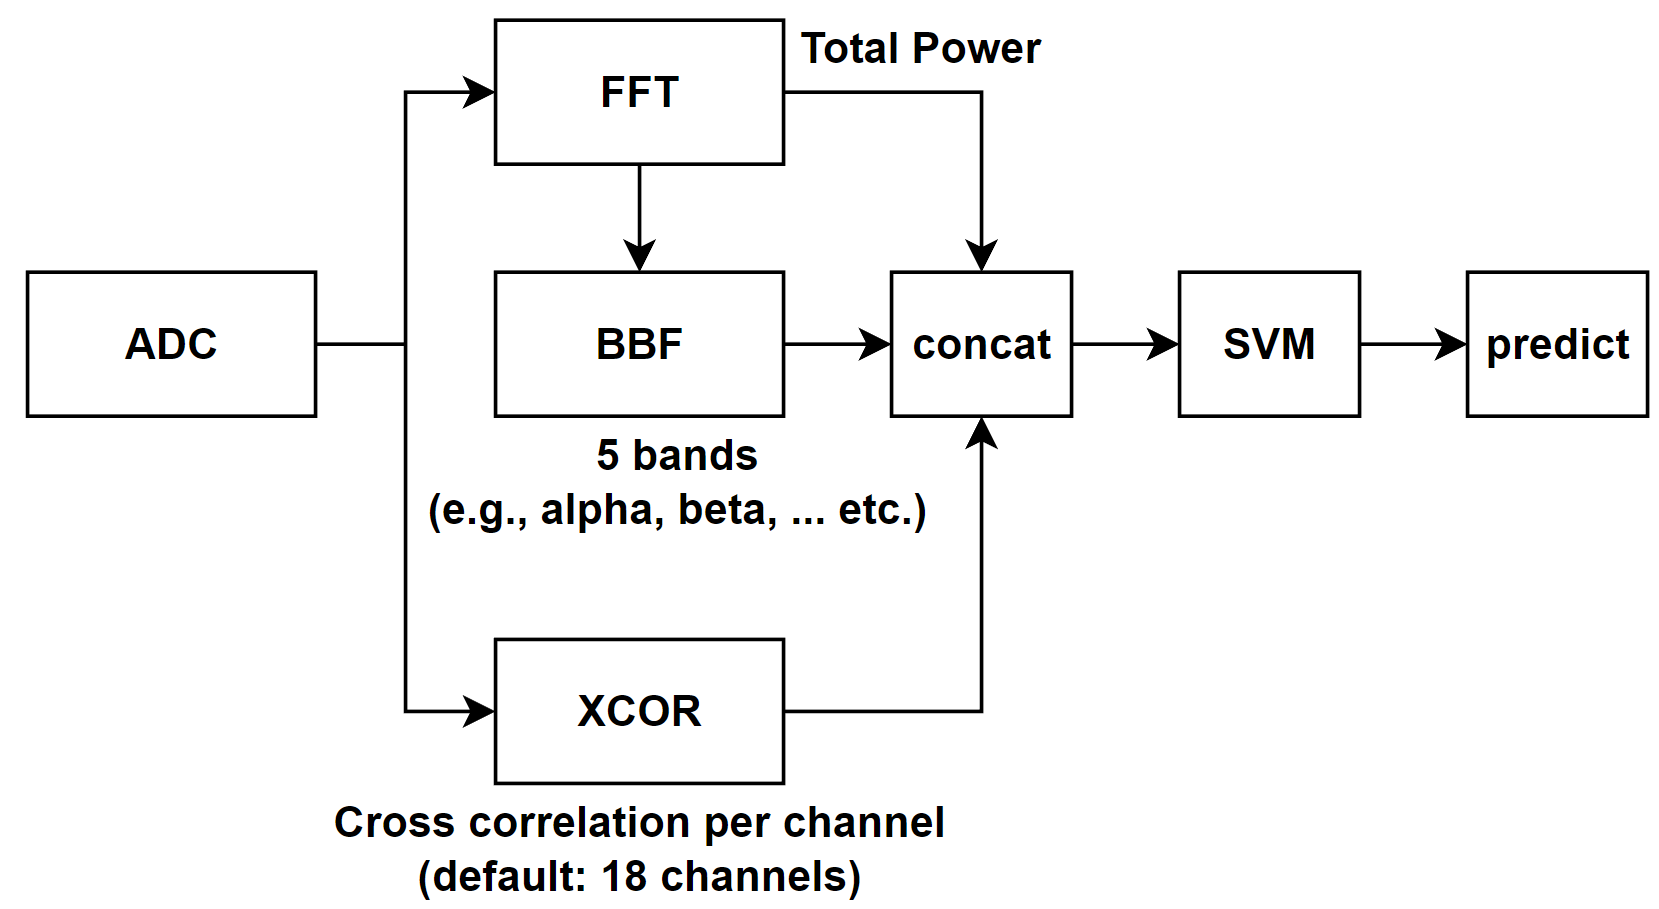

## Step 1: Cut ADC Long Sample into Windows
- The output of the ADC can be a long string of samples.
- In the CHB-MIT data set, the assumes sampling frequency is $f_s = 250 Hz$ and therefore each second has 250 samples.
- Some patient samples can range up to hours, (E.g., patient 1 has an hour of recording) and seizures can last up to a few mins (e.g., 3 mins.)
- Visually the slicing is shown in the figure below.
- This slicing when run on the python code can be treated like a simple pre-process of the original data.
- There are a lot of data overlap because the windows need to be at least 50% overlap for better accuracy.

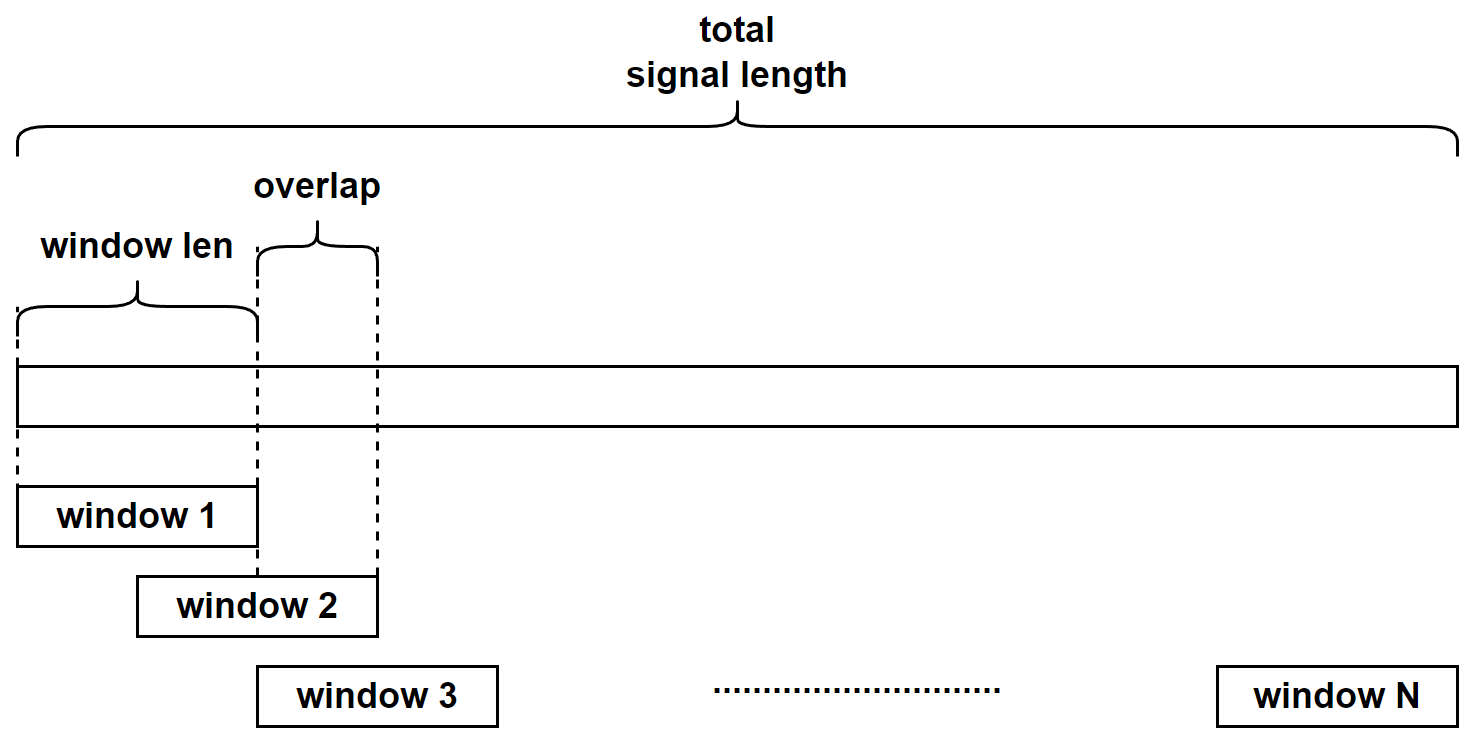